# Iris MLP - multi-task - patient model

This is training the model we are going to study.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
from physics_mi.eval import plot_loss
from torch import nn
from tqdm.notebook import tqdm

In [3]:
class config:
    EPOCHS = 200
    LR = 1e-1

    N_SAMPLES = 50
    BOTTLE_DIM = 4

## Data

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset from sklearn
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_valid = torch.tensor(y_test, dtype=torch.int64)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(torch.Size([120, 4]),
 torch.Size([120]),
 torch.Size([30, 4]),
 torch.Size([30]))

Now to create the stacked datasets:

In [5]:
from torch.utils.data import Dataset, DataLoader


class MultiIris(Dataset):
    def __init__(self, X, y):
        shuffled_indices = torch.randperm(len(X))
        self.X = torch.cat((X, X[shuffled_indices]), dim=1)
        self.y = torch.stack((y, y[shuffled_indices])).T

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
train_ds = MultiIris(X_train, y_train)
valid_ds = MultiIris(X_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=len(train_ds), shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([120, 8]), torch.Size([120, 2]))

## Model

In [7]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # cba messing with the dataset that's already neatly packaged
        return self.layers(x)

## Loss function

In [8]:
class MultiIrisLoss(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, y_pred, y_true):
        return self.loss(y_pred[:, :3], y_true[:, 0]) + self.loss(y_pred[:, 3:], y_true[:, 1])

## Training

In [9]:
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR

model = Net(input_dim=8, hidden_dim=64, output_dim=2 * y_train.unique().shape[0])
optimiser = Adam(model.parameters(), lr=config.LR, weight_decay=1e-2)
loss_func = MultiIrisLoss()
total_steps = len(X_train) * config.EPOCHS
scheduler = OneCycleLR(optimiser, max_lr=config.LR, total_steps=total_steps)

Xb_valid, yb_valid = next(iter(valid_dl))

log = []

for epoch in tqdm(range(config.EPOCHS)):
    # Reinitialise the train set to shuffle the combinations
    train_ds = MultiIris(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=len(train_ds), shuffle=True)
    xb, yb = next(iter(train_dl))

    log_sample = {}

    model.train()
    y_hat = model(xb)
    loss = loss_func(y_hat, yb)
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        y_hat = model(Xb_valid)
        valid_loss = loss_func(y_hat, yb_valid)

    log_sample["valid_loss"] = float(valid_loss)
    log_sample["train_loss"] = float(loss)
    log.append(log_sample)

log = pd.DataFrame(log)

  0%|          | 0/200 [00:00<?, ?it/s]

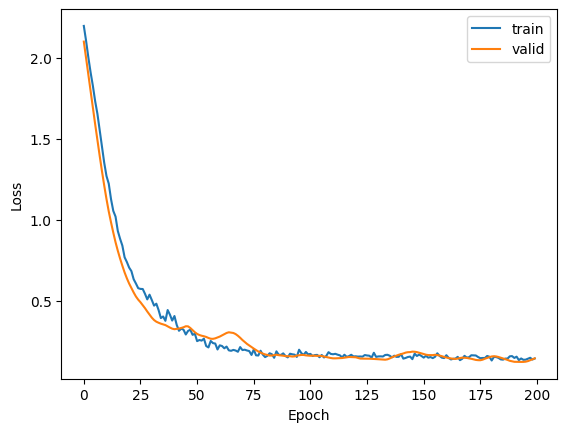

In [10]:
plot_loss(log["train_loss"], log["valid_loss"])

## Results

In [11]:
def get_preds(model, X_valid, y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = y_valid.numpy()

    return y_preds, y_targs

In [12]:
y_preds, y_targs = get_preds(model, Xb_valid, yb_valid)
y_preds_A, y_preds_B = y_preds[:, :3], y_preds[:, 3:]
y_targs_A, y_targs_B = y_targs[:, 0], y_targs[:, 1]
y_preds_A = np.argmax(y_preds_A, axis=1)
y_preds_B = np.argmax(y_preds_B, axis=1)

print(f"Accuracy A: {(y_preds_A == y_targs_A).mean()}")
print(f"Accuracy B: {(y_preds_B == y_targs_B).mean()}")

Accuracy A: 0.9666666666666667
Accuracy B: 0.9666666666666667


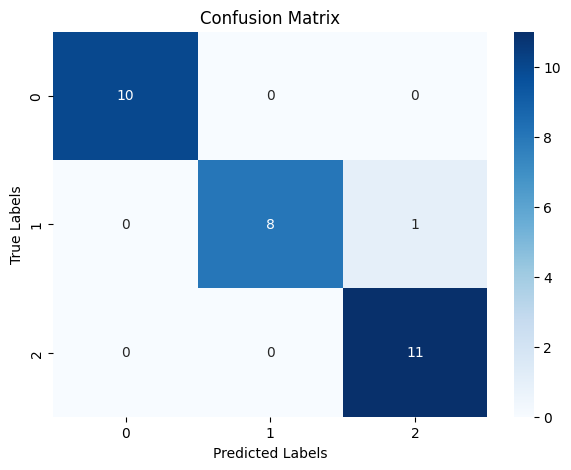

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_targs_A, y_preds_A)

# Plotting the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

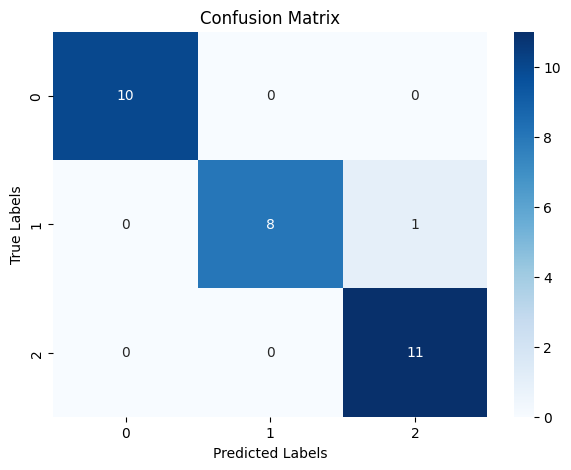

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_targs_B, y_preds_B)

# Plotting the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Task independence

I'm keen to produce some plots like I did in `007-comp-graph/005-soft-mixing`.

In [15]:
from physics_mi.analysis import capture_intermediate_outputs
from physics_mi.graph import generate_graph
from physics_mi.analysis import plot_similarity_matrix, get_sims

In [16]:
valid_ios = capture_intermediate_outputs(model, Xb_valid)
valid_ios["input"] = Xb_valid

In [17]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx : lidx + 1]
        out = sub_net(linputs)
        return out


scaffold_model = ScaffoldNet(input_dim=8, hidden_dim=64, output_dim=2 * y_train.unique().shape[0])
scaffold_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [18]:
ios = valid_ios
layer_keys = [
    "input",
    "layers.0.act",
    "layers.1.act",
    "layers.2.linear.bias",
]  # these are where from we would like to extract the components

In [19]:
ndf, edf = generate_graph(ios, layer_keys, scaffold_model)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

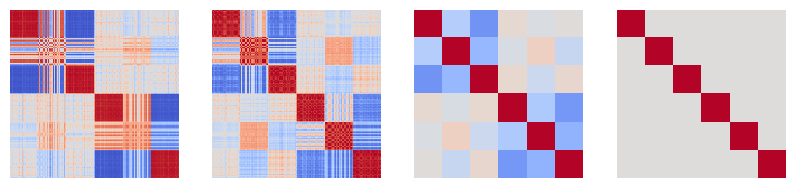

In [20]:
fig, axes = plt.subplots(1, len(layer_keys), figsize=(10, 10))

for ax, key in zip(axes, layer_keys):
    sims = get_sims(ndf, key)
    plot_similarity_matrix(sims, ax=ax, axis=False, colorbar=False)

Our two independent Iris tasks looking pretty neat.

In [21]:
# torch.save(model.state_dict(), "models/iris-mlp.pth")

I'm going to start a new notebook now just to avoid confusion with all the models around 🙈